In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
dim = 512
num_samples = 20000
X = np.random.randn(num_samples,dim)

w_gen = np.random.rand(dim)
error = np.random.randn(num_samples) # normally distributed

y = X @ w_gen + 3*error # unscaled errors currently

w_true = np.linalg.lstsq(X,y,rcond=-1)[0]
true_residual = X @ w_true - y

In [15]:
w_init = np.random.rand(X.shape[1])

In [47]:
def train_model(X,y,w,iterations,batch_size,method='vanilla',pbs=False):
    residuals = []
    w_true_conv = []
    w_gen_conv = []
    
    for i in range(iterations):

        # if method == 'divbs' and i > 3:
        #     method = 'opt'

        if method == 'vanilla':
            selected_idx = np.random.choice(X.shape[0],size=batch_size)

        elif method == 'rholoss':
            model_residual = X @ w - y
            reducible_loss = model_residual**2 - true_residual**2
            # if i == 50:
            #         plt.hist(reducible_loss,bins=1000)
            #         plt.show()
            if pbs:
                priorities = np.exp(reducible_loss - np.max(reducible_loss))
                probs = priorities / np.sum(priorities)
                try:
                    selected_idx = np.random.choice(X.shape[0],p=probs,replace=False,size=batch_size)
                except Exception as e:
                    print(priorities)
                    raise RuntimeError(f"Error in Kaczmarz update at iteration {i}: {e}")
            else:
                selected_idx = np.argsort(-reducible_loss)[:batch_size]

        elif method == 'divbs':
            model_residual = X @ w - y
            grads = X * model_residual[:, np.newaxis]

            # Factor in optimal criterion
            opt_criterion = model_residual**2 - 2 * model_residual * true_residual
            z_scores = (opt_criterion - opt_criterion.mean()) / opt_criterion.std()
            scores = 1 / (1 + np.exp(z_scores / 16))
            # sorted_opt = np.argsort(-opt_criterion)[:batch_size]
            sorted_opt = np.argsort(-opt_criterion)
            opt_ranking = np.array(range(len(sorted_opt)))[sorted_opt]
            # grads = grads[sorted_opt]
            # opt_criterion /= opt_criterion.sum()
            grads = grads * scores[:, np.newaxis]

            residual = grads.sum(axis=0).T
            selected_idx = []
            D = grads
            selected_element = []


            for j in range(batch_size):
                # correlations = np.abs((D @ residual) * opt_criterion)
                correlations = np.abs(D @ residual)
                correlations = correlations / correlations.sum()
                if pbs:
                    idx = np.random.choice(len(D), 1, p=correlations).item()
                else:
                    # sorted_corr = np.argsort(-correlations)
                    # corr_ranking = np.array(range(len(sorted_corr)))[sorted_corr]
                    # idx = np.argmin(sorted_corr + corr_ranking)
                    idx = np.argmax(correlations)
                # ensure first selected vector is the best one
                # if j < 10:
                #     idx = sorted_opt[j]
                
                selected_idx.append(idx)
                if len(selected_element) > 0:
                    selected_element_matrix = np.array(selected_element)
                    D_selected = D[idx, :] - selected_element_matrix.T @ (selected_element_matrix @ D[idx, :])
                else:
                    D_selected = D[idx, :]
                D_selected = D_selected/ np.linalg.norm(D_selected)
                selected_element.append(D_selected)

                
                residual = residual - np.dot(D_selected, residual)* D_selected
            
            # selected_idx = sorted_opt[selected_idx]


        elif method == 'opt':
            model_residual = X @ w - y
            opt_criterion = model_residual**2 - 2 * model_residual * true_residual
            # if i == 50:
            #         plt.hist(opt_criterion,bins=1000)
            #         plt.show()
            if pbs:
                priorities = np.exp(opt_criterion - np.max(opt_criterion))
                probs = priorities / np.sum(priorities)
                try:
                    selected_idx = np.random.choice(X.shape[0],p=probs,replace=False,size=batch_size)
                except Exception as e:
                    print(priorities)
                    raise RuntimeError(f"Error in Kaczmarz update at iteration {i}: {e}")
            else:
                selected_idx = np.argsort(-opt_criterion)[:batch_size]


        
        
        selected_X = X[selected_idx]

        # Compute projection
        # true_b_tau = selected_X @ w_true ####### This line wrecked me
        true_b_tau = y[selected_idx]
        model_b_tau = selected_X @ w

        # Standard Kaczmarz update (multiple rows)
        w = w - np.linalg.pinv(selected_X) @ (model_b_tau - true_b_tau)

        residuals.append(np.linalg.norm(X @ w - y))
        w_true_conv.append(np.linalg.norm(w - w_true))
        w_gen_conv.append(np.linalg.norm(w - w_gen))
    
    return residuals, w_true_conv, w_gen_conv

method: vanilla, residual error: 637.2133451642959
method: rholoss, residual error: 532.550538693075
method: divbs, residual error: 530.3962266050536
method: opt, residual error: 418.5804174783326


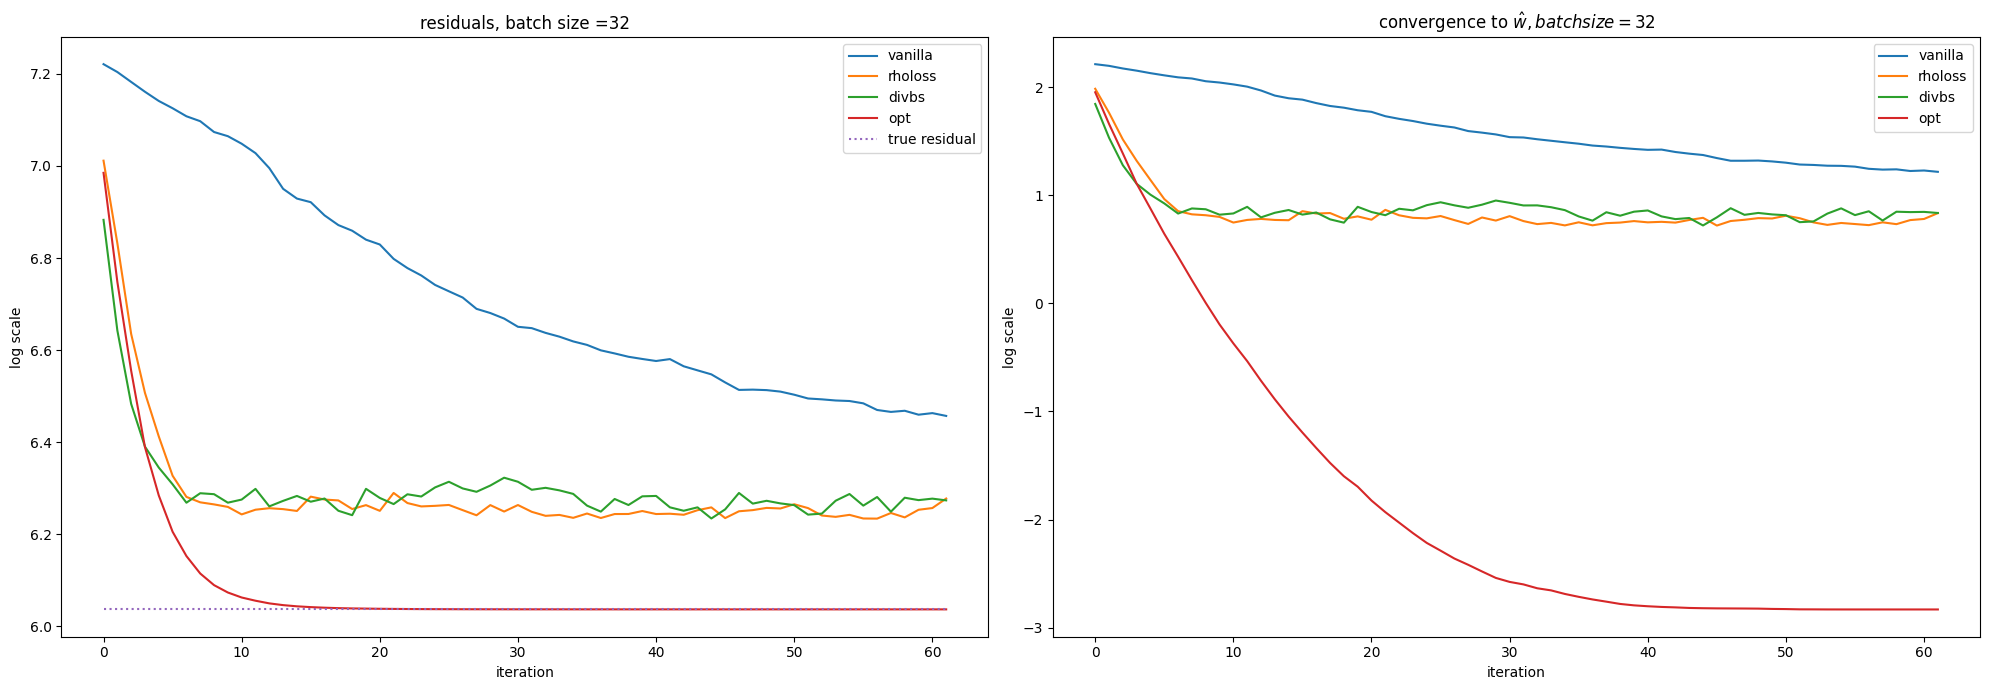

In [ ]:
methods = ['vanilla', 'rholoss', 'divbs', 'opt']
k=32
iterations = num_samples // (10*k)
# iterations = num_samples // (5*k)

lr = 0.000001

fig, axes = plt.subplots(1,2,figsize=(20,7))

for method in methods:
    residuals, w_true_conv, w_gen_conv = train_model(X,y,w_init.copy(),iterations,k,method=method)
    axes[0].plot(range(iterations), np.log(residuals), label=method)
    axes[1].plot(range(iterations), np.log(w_true_conv), label=method)
    # axes[2].plot(range(iterations), np.log(w_gen_conv), label=method)
    
    print(f'method: {method}, residual error: {residuals[-1]}')

    # if method != 'vanilla':
    #     # PBS
    #     residuals, w_true_conv, w_gen_conv = train_model(X,y,w_init.copy(),iterations,k,method=method, pbs=True)
    #     axes[0].plot(range(iterations), np.log(residuals), label=f'PBS {method}')
    #     axes[1].plot(range(iterations), np.log(w_true_conv), label=f'PBS {method}')
    #     # axes[2].plot(range(iterations), np.log(w_gen_conv), label=f'PBS {method}')
    #     print(f'method: PBS {method}, residual error: {residuals[-1]}')
    
    axes[0].set_title(f'residuals, batch size ={k}')
    axes[0].set_ylabel('log scale')
    axes[0].set_xlabel('iteration')
    

    axes[1].set_title(r'convergence to $\hat{w}, batch size =$' + f'{k}')
    axes[1].set_ylabel('log scale')
    axes[1].set_xlabel('iteration')
    axes[1].legend()

axes[0].plot(range(iterations), np.log([np.linalg.norm(true_residual)]*iterations), label='true residual', linestyle=':')
axes[0].legend()

plt.tight_layout()
plt.show()

All three are log scale. $\hat{w}$ is the true solution, whereas $w^*$ was the generating vector before noise was added.

Can we try using the optimal update in our deep learning framework? Also, it appears that PBS opt may do slightly better at the start when sample size is larger.

DivBS consistently outperforms RHO-Loss

Important to note that these are training loss curves, not generalization loss

I have tried the following variatiations with no success:
 - sum together the rankings of opt and the rankings of the correlations and pick one by one in this fashion
 - a prefilter where only the top 320 ranked based on opt are considered and then we perform DivBS on it
 - a weighted DivBS where the gradients are weighted by the opt scores

The only thing that worked well was switching from DivBS to Opt after 3 or so steps